# Test EV control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ev_ssm import ev_ssm
from tqdm import tqdm
import scipy.stats as stats

In [2]:
# --- Response ---

sse = ev_ssm(ts=18, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA",
             n_pref=1, is_report=True,
             tt_mean=0.5, tt_var=0.2, tt_lb=0, tt_ub=1)
sse.load_A("Aest.csv")


EVA: ts=18[H], 10000 EVs, Total Q=87.83 MWh
Online 2955, Q=73.98 MWh, SoC=0.7712
Power(MW): Pt=-8.1388, Pc=-8.1388, Pd=-0.0
Ctrl: 0=1581; 1=1374; 
EVA: Load A from Aest.csv.


<AxesSubplot:>

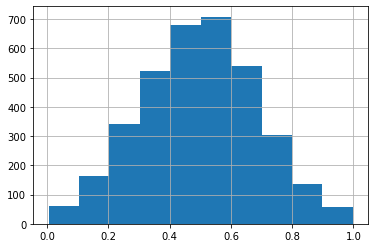

In [3]:
sse.ev.tt.hist()

In [9]:
sse.ev['nam'] = ((sse.ev['tf'].mean() - sse.ev['ts'].mean()) * sse.ev['Pc'].mean() * sse.ev['nc'].mean()
                 - sse.ev['socd'] * sse.ev['Q']) / (sse.ev['Pc'].mean() * sse.ev['nc'].mean() * 4 / 3600)
sse.ev['nam'] = sse.ev['nam'].astype(int)
sse.ev['na'] = sse.ev[['na', 'nam']].max(axis=1)

,u,u0,soc,bd,c,c2,c0,sx,dP,xl,...,Q,ts,tf,tt,pref,lc,agc,mod,na,nam
2404,0,0,0.380920,0,0,1,0,7,0,"[[], [], []]",...,29.627869,18.624638,23.535176,0.856610,0,0,0,0,2284,2271
3076,1,1,0.458524,0,1,0,0,9,0,"[[], [], []]",...,29.344307,17.703476,23.347899,0.954765,0,0,0,0,2240,2214


<AxesSubplot:>

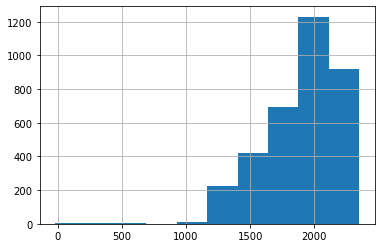

In [5]:
sse.ev.na.hist()

<AxesSubplot:>

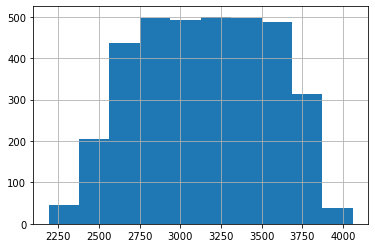

In [6]:
sse.ev.nam.hist()

<AxesSubplot:>

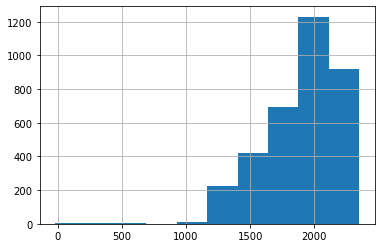

In [7]:
sse.ev.na.hist()

In [ ]:
na[na <= 0]

In [ ]:
na = stats.truncnorm((-2000 - 100 * (sse.ev['tf'] - 18)) / (sse.ev['soci'] * 100),
                (8000 - 100 * (sse.ev['tf'] - 18)) / (sse.ev['soci'] * 100),
                loc=100 * (sse.ev['tf'] - 18), scale=sse.ev['soci'] * 100).rvs(3438)
plt.hist(na)

In [ ]:
100 * (sse.ev['tf'] - 18)

In [ ]:
sse.ev

In [ ]:
%run -i 'cosim_import.py'

In [ ]:
caseH = 18
%run -i 'cosim_setup_andes.py'

In [ ]:
%run -i 'cosim_loadsyn.py'

In [ ]:
%run -i 'cosim_setup_dispatch.py'

In [ ]:
%run -i 'cosim_linktable.py'

In [ ]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 3600

rru, rrd, rsfr = 1.0, 1.0, 0.04

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Revise the EV control logic as: C->I, I->D, SOC high to low

In [ ]:
# --- Response ---

sse = ev_ssm(ts=18, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA")
sse.load_A("Aest.csv")


In [ ]:
sse.ev['Qa'] = (sse.ev['tf'] - sse.ev['ts']) * sse.ev['Pc'] * sse.ev['nc'] - sse.ev['socd'] * sse.ev['Q']
sse.ev['Qr'] = sse.ev['Qa'].mean() + sse.ev['tt'] * sse.ev['Pd']
sse.ev['nr'] = sse.ev['Qr'] / sse.ev['Pc'] / sse.ev['nc'] * 3600 / 4

sse.ev['nr'].hist()

sse.ev['Qa'].mean()

In [ ]:
# --- Response ---

sse = ev_ssm(ts=10.4, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA")
sse.load_A("Aest.csv")

x0 = sse.x0.copy()
print(sse.Prc)
sse.run(tf=10.4 + 2/3600, Pi=9,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=False)
print(sse.Prc)
x1 = sse.x0.copy()

In [ ]:
plt.bar(range(len(x0)), x0, label="x0")
plt.bar(range(len(x0)), x1, label="x0", alpha=0.5)

In [ ]:
sse = ev_ssm(ts=10.4, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA",
             is_report=False)

# historical data
ev_num = pd.read_csv("ev_num.csv")

# calculate the sf
k1 = ev_num['ne'][(ev_num['time'] >= sse.ts) & (ev_num['time'] <= sse.ts+1/12)].mean()
k0 = ev_num['ne'][ev_num['time'] >= sse.ts].iloc[0]
k = k1 / k0

# estiamte FRC
sse.g_frc(nea=sse.ne*k)

In [ ]:
## Run to get the EV numbers within a day

# import joblib
# from joblib import Parallel, delayed

# Nt = 10000
# def rne(time):
#     sse1 = ev_ssm(ts=time, N=Nt, step=1, tp=40,
#                   lr=0.1, lp=60, seed=2022, name="EVA",
#                   is_report=False)
#     return sse1.ne

# # interval by minutes, 24H
# rnel = Parallel(n_jobs=joblib.cpu_count())(delayed(rne)(i) for i in np.arange(1/60, 24, 1/60))

# ev_num = pd.DataFrame()
# ev_num['time'] = np.arange(1/60, 24, 1/60)
# ev_num['ne'] = rnel
# ev_num.to_csv("ev_num.csv", index=False)